# Installs

In [ ]:
pip install earthengine-api

In [ ]:
pip install earthengine-api --upgrade

In [1]:
pip install earthpy

  Using cached earthpy-0.9.4-py3-none-any.whl (1.4 MB)
  Using cached rasterio-1.2.10.tar.gz (2.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Mudo\anaconda3\python.exe' 'C:\Users\Mudo\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\Mudo\AppData\Local\Temp\tmp1y4nikho'
       cwd: C:\Users\Mudo\AppData\Local\Temp\pip-install-awvlk09l\rasterio
  Complete output (2 lines):
  INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
  ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
  ----------------------------------------
ERROR: Command errored out with exit status 1: 'C:\Users\Mudo\anaconda3\python.exe' 'C:\Users\Mudo\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\Mudo\AppData\Local\Temp\tmp1y4nikho' Check the logs for full command output.


In [ ]:
pip install geehydro

In [ ]:
!pip install geemap

# Main Code

## Imports and Library authentication

In [14]:
import ee
from datetime import datetime as dt

import earthpy as ep
from glob import glob

import geemap
import geehydro
import pandas as pd
import numpy as np
import folium

import requests
import json
import urllib

import earthpy.spatial as es

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

from IPython.display import Image
from tqdm import tqdm

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


# Re-usable Code

In [5]:
class Landsat: 
  def __init__(self, name, short_name, start_date, end_date):
    self.name = name
    self.short_name = short_name
    self.start_date = start_date
    self.end_date = end_date

LANDSAT_5 = Landsat("LANDSAT/LT05/C01/T1_8DAY_NDVI", "LANDSAT 5" ,"1984-01-01", "2012-04-30") # 36 years of data 
LANDSAT_7 = Landsat("LANDSAT/LE07/C01/T1_8DAY_NDVI", "LANDSAT 7" ,"1999-01-01", "2022-01-01") # 22 years of data
LANDSAT_8 = Landsat("LANDSAT/LC08/C01/T1_8DAY_NDVI", "LANDSAT 8" ,"2013-04-07", "2022-01-01") # 09 years of data

In [28]:
class UsNdviModel:
  def __init__(self, name, state, map_center=[0,0]):
    """
      name (str): The name of the city/county
      state (str): The 2-letter state code
      map_center (list): A list of lat and long coordinates to draw the map center
    """
    self.name = name
    self.state = state
    self.map_center = map_center
    self.queryBoundaries()
  
  ########################################################
  ## ------- City Boundaries & Map Visualizations --------
  def queryBoundaries(self, save_local=False):
    # Define API URL
    url = "https://vanitysoft-boundaries-io-v1.p.rapidapi.com/reaperfire/rest/v1/public/boundary/place/{}/state/{}"\
          .format(urllib.parse.quote(self.name), self.state)

    headers = {
      'x-rapidapi-host': "vanitysoft-boundaries-io-v1.p.rapidapi.com",
      'x-rapidapi-key': "9da6bd4c09mshc9402238f008d06p194bb4jsnd0a2ba951eaa"
      }
      
    response = requests.request("GET", url, headers=headers)
    
    _json = json.loads(response.text)
    
    if save_local:
      # the json file where the output must be stored
      _filename = f"{self.name}-{self.state}.json"
      out_file = open(_filename, "w")
      json.dump(_json, out_file, indent = 3)
      out_file.close()

    self._boundaries = geemap.geojson_to_ee(_json)
    return self._boundaries    
  
  def drawMapWithBoundaries(self, zoom=12):
    """ 
      Input: 
        zoom (int): Optional argument for initial map zoom
      Output:
        Returns a Folium map centered at self.map_center
    """
    map = folium.Map(location=self.map_center, zoom_start=zoom)
    map.addLayer(self._boundaries)
    return map

  def visualizeNdvi(self, landsat_obj, start=" ", end=" "):
    """
     
    """
    landsat = ee.ImageCollection(landsat_obj.name)
    start_date = start if start != "" else landsat_obj.start_date
    end_date = start if end != "" else landsat_obj.end_date

    landsat_AOI = landsat.filterBounds(self._boundaries).\
                  filterDate(start_date,end_date)

    palette = [
      'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301']

    ndvi_parameters = {'min': 0,
                      'max': 1,
                      'dimensions': 512,
                      'palette': palette}

    map = self.drawMapWithBoundaries()
    map.addLayer(landsat_AOI.clip(self._boundaries), ndvi_parameters)
    return map
  
  #################################################
  # ------ NDVI Computations & Manipulation -------

  def singleLandsatHistoricalNdvi(self, landsat_obj:Landsat, start:str = "", end:str = "", show_logs=False):
    """
      Creates a pandas dataframe with the monthly avg ndvi for a specific Landsat
      Input:
      - landsat_obj (Landsat): Which landsat to extract data from
      - start (str, optional): Date to start filtering data. 
      - end (str, optional): Date to end filtering data. 
      * obs: if start or end is not provided, the default dates are the Landsat's
            date range 
      Outputs:
      - A pandas dataframe with the monthly ndvi
    """

    landsat = ee.ImageCollection(landsat_obj.name)
    start_date = start if start != "" else landsat_obj.start_date
    end_date = end if end != "" else landsat_obj.end_date

    if show_logs:
      print("Gathering NDVI from "+ landsat_obj.short_name + " from {} to {}"
          .format(start_date, end_date))

    start_year, end_year = int(start_date.split('-')[0]), int(end_date.split('-')[0])
    landsat_AOI = landsat.filterBounds(self._boundaries).filterDate(start_date,end_date)

    
    global COLLECTION, BOUNDARIES, MONTHS
    COLLECTION = landsat_AOI
    BOUNDARIES = self._boundaries
    
    MONTHS = ee.List.sequence(1,12)
    years = ee.List.sequence(start_year,end_year)

    output = years.map(yearFunc).getInfo()
    df = self.convertToDataFrame(output, landsat_obj.short_name)
    
    self.df = df
    return df


  def mergeLandsatData(self, show_logs=False):
    """
      Creates a pandas dataframe with the monthly avg ndvi for ALL Landsats
    """
    # Because there is a limit amount of data, we get Landsat data in batches
    # We use LANDSAT 5 and LANDSAT 7 to gather data from 1984 to 2022
    data_frames = []
    start_year, end_year = 1984, 2022
    curr_year = start_year
    yr_batch = 3

    while curr_year < end_year:
      landsat = LANDSAT_5 if curr_year < 1999 else LANDSAT_7 
      upper_bound = curr_year + yr_batch
      if upper_bound > end_year:
        upper_bound = end_year
      
      data_frames.append(self.singleLandsatHistoricalNdvi(landsat, f"{curr_year}-01-01", f"{upper_bound}-01-01", show_logs=show_logs))

      curr_year = upper_bound
      
    merged_df = pd.concat(data_frames)
    self.merged_df = merged_df.copy()
    return merged_df

  def saveDataFrameToCSV(self, filepath=""):
    if not hasattr(self, "merged_df"):
      self.mergeLandsatData()

    if filepath=="":
      filepath = '{}_{}.csv'.format(self.name, self.state)

    self.merged_df.to_csv(filepath, index=False)

  ################################
  #---------- PLOTS -----------

  def plotNdvi(self, figsize=(30,15)):
    """
    """
    if not hasattr(self, "df"):
      raise Exception("You must run 'singleLandsatHistoricalNdvi' before executing this function")

    plt.figure(figsize=figsize)
    plt.plot(self.df["month-year"], self.df["NDVI"], '-o', label=self.df["landsat"][0])

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gcf().autofmt_xdate() # Rotation
    plt.legend()
    plt.show()
  
  def plotMergedNdvi(self, figsize=(20,12)):
    """
    """
    if not hasattr(self, "merged_df"):
      self.mergeLandsatData()
    
    _df = self.merged_df

    plt.figure(figsize=(20,12))
    landsats = list(np.unique(_df["landsat"]))
    for val in landsats:
      plt.plot(_df.loc[_df["landsat"]==val]["month-year"], _df.loc[_df["landsat"]==val]["NDVI"], label=val)

    year_avg = self.merged_df.groupby(pd.Grouper(key='month-year', freq='1Y')).mean()
    plt.plot(year_avg["NDVI"].keys(), year_avg["NDVI"].values, '-o', label="Yearly average")
    
    plt.legend()
    plt.show()


  ###############################
  #------- HELPER METHODS -------
  def convertToDataFrame(self, output, landsat_short_name):
    ndvi_list = []
    date_list = []

    for lst in output:
      for dic in lst:
        if "NDVI" in dic and dic["NDVI"] != None:
          ndvi_list.append(dic["NDVI"])
          date_list.append("{}-{}".format(dic["month"], dic["year"]))

    data = {"NDVI":ndvi_list, "month-year":date_list}
    df =  pd.DataFrame(data)
    df["month-year"] = pd.to_datetime(df["month-year"], format="%m-%Y")
    df["landsat"] = landsat_short_name

    return df

In [42]:
def yearFunc(_y):
  global y, MONTHS
  y=_y
  return MONTHS.map(monthFunc).flatten()

def monthFunc(m):
  global y, COLLECTION, BOUNDARIES
  return (COLLECTION
      .filter(ee.Filter.calendarRange(y,y,"year"))
      .filter(ee.Filter.calendarRange(m,m,'month'))
      .mean()
      .reduceRegion(ee.Reducer.mean(), BOUNDARIES, 30, maxPixels=30e9)
      .set('year', y)
      .set('month', m))

## Examples

### Seattle, WA

In [31]:
seattle = UsNdviModel("Seattle", "WA", [47.6062, -122.3321])

In [32]:
seattle.drawMapWithBoundaries()

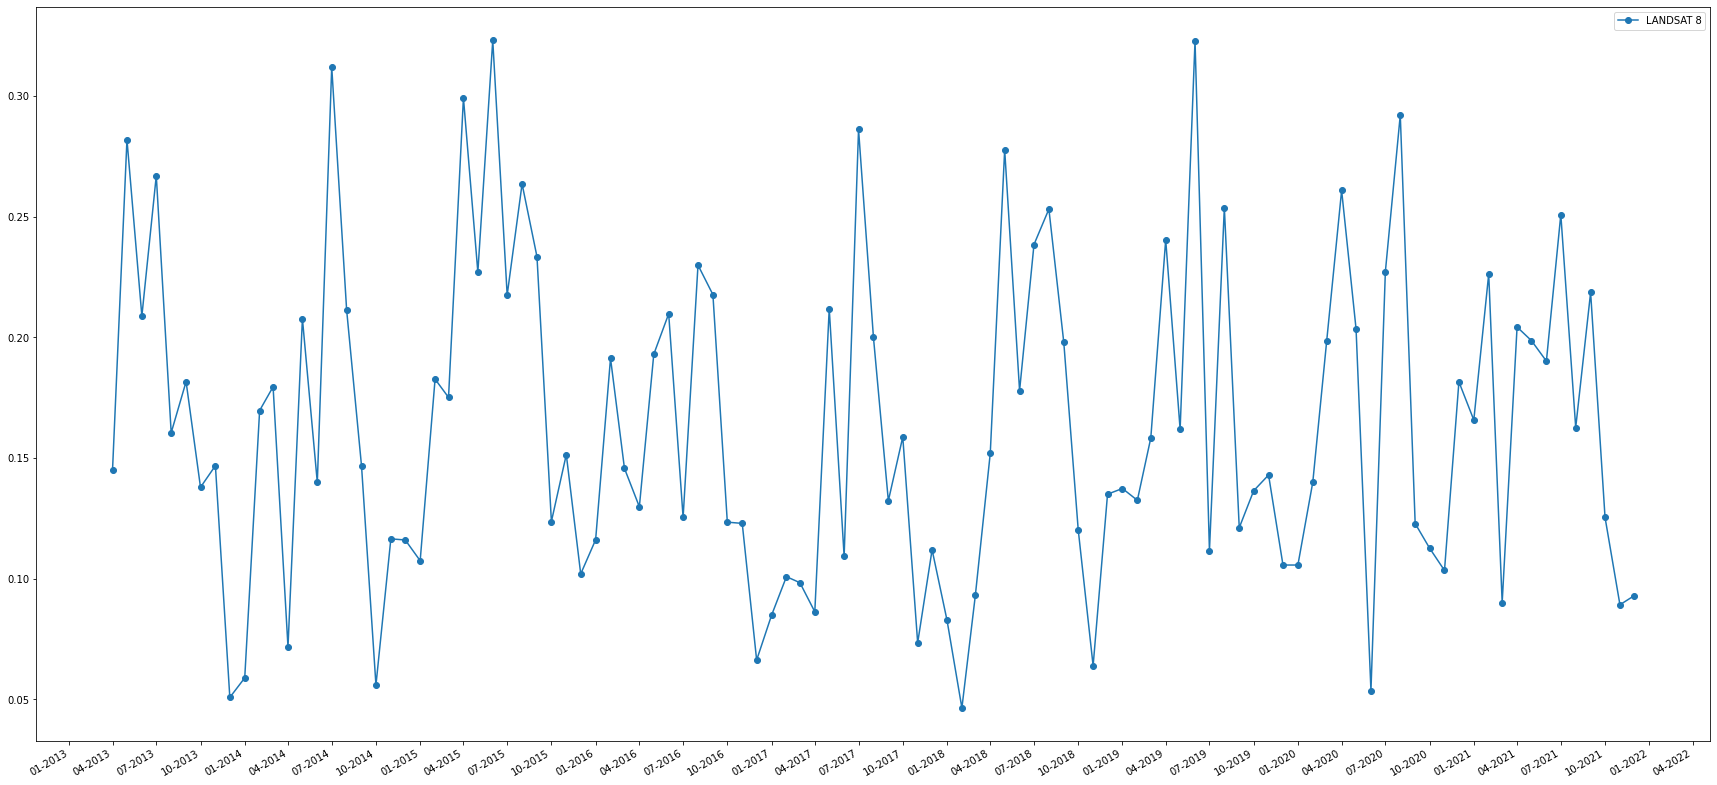

In [33]:
seattle_df = seattle.singleLandsatHistoricalNdvi(LANDSAT_8)
seattle.plotNdvi()

In [34]:
merged_df = seattle.mergeLandsatData()
merged_df

,NDVI,month-year,landsat
0,0.262032,1984-04-01,LANDSAT 5
1,0.263340,1984-06-01,LANDSAT 5
2,0.231436,1984-07-01,LANDSAT 5
3,0.256356,1984-08-01,LANDSAT 5
4,0.030448,1984-10-01,LANDSAT 5
...,...,...,...
18,0.206088,2021-07-01,LANDSAT 7
19,0.262852,2021-08-01,LANDSAT 7
20,0.036042,2021-10-01,LANDSAT 7
21,0.030224,2021-11-01,LANDSAT 7


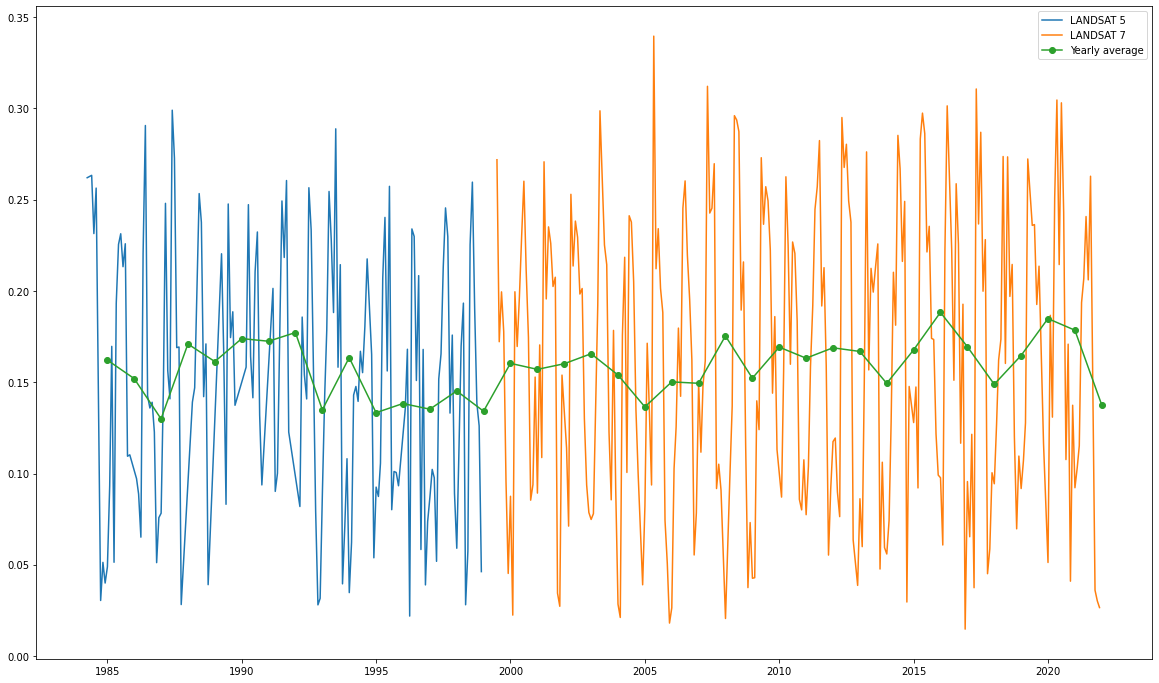

In [35]:
seattle.plotMergedNdvi()

### Houston, TX

In [ ]:
houston = UsNdviModel("Houston", "TX", [29.759527, -95.355758])

In [ ]:
houston.drawMapWithBoundaries()

In [ ]:
df = houston.mergeLandsatData()

Gathering NDVI from LANDSAT 5 from 1984-01-01 to 1987-01-01
Gathering NDVI from LANDSAT 5 from 1987-01-01 to 1990-01-01
Gathering NDVI from LANDSAT 5 from 1990-01-01 to 1993-01-01
Gathering NDVI from LANDSAT 5 from 1993-01-01 to 1996-01-01
Gathering NDVI from LANDSAT 5 from 1996-01-01 to 1999-01-01
Gathering NDVI from LANDSAT 7 from 1999-01-01 to 2002-01-01
Gathering NDVI from LANDSAT 7 from 2002-01-01 to 2005-01-01
Gathering NDVI from LANDSAT 7 from 2005-01-01 to 2008-01-01
Gathering NDVI from LANDSAT 7 from 2008-01-01 to 2011-01-01
Gathering NDVI from LANDSAT 7 from 2011-01-01 to 2014-01-01
Gathering NDVI from LANDSAT 7 from 2014-01-01 to 2017-01-01
Gathering NDVI from LANDSAT 7 from 2017-01-01 to 2020-01-01
Gathering NDVI from LANDSAT 7 from 2020-01-01 to 2022-01-01


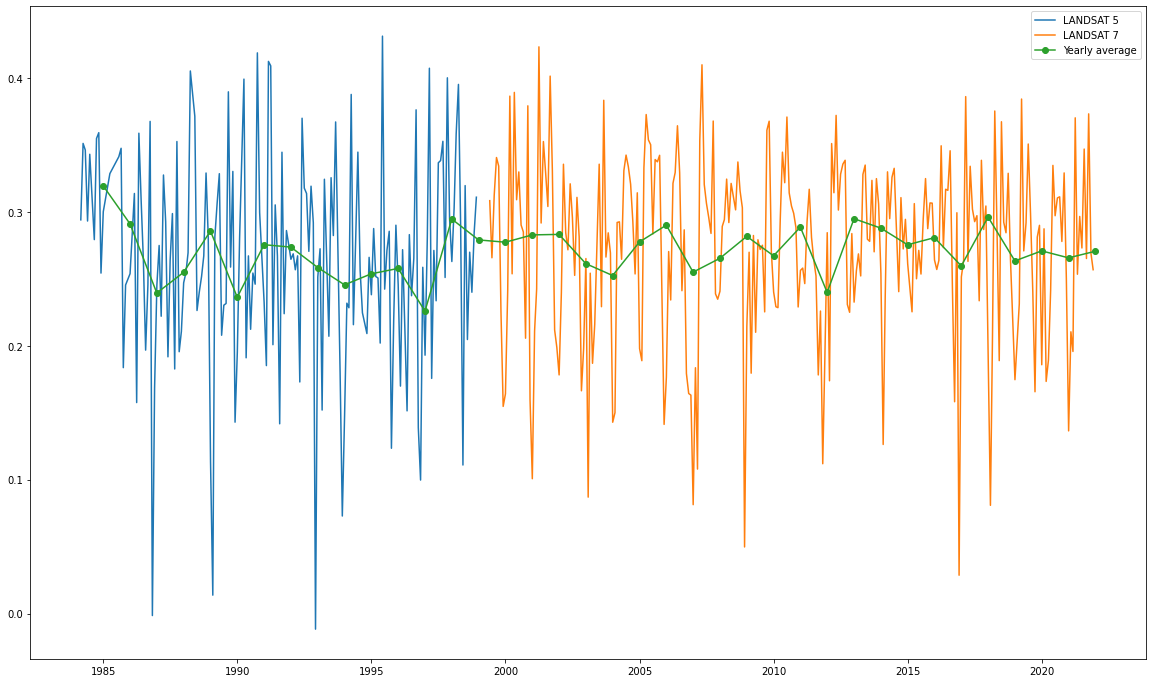

In [ ]:
houston.plotMergedNdvi()

In [ ]:
houston.saveDataFrameToCSV()

### Indianopolis, IN

In [ ]:
indianapolis = UsNdviModel("Indianapolis", "IN", [39.766734, -86.156744])

In [ ]:
indianapolis.drawMapWithBoundaries()

In [ ]:
indianapolis.singleLandsatHistoricalNdvi(LANDSAT_7)

Calculating NDVI from LANDSAT 7
1999 2022


KeyboardInterrupt: ignored

## Generate CSV Files

In [38]:
path = "../data/us-states-territories.csv"
with open(path, encoding="utf8", errors='ignore') as f:
    us_df = pd.read_csv(f, usecols=["Type", "Name", "Abbreviation","Capital"])

us_df.head()

,Type,Name,Abbreviation,Capital
0,State,Alabama,AL,Montgomery
1,State,Alaska,AK,Juneau
2,State,Arizona,AZ,Phoenix
3,State,Arkansas,AR,Little Rock
4,State,California,CA,Sacramento


In [39]:
us_df = us_df.loc[us_df["Type"] == "State"]

In [40]:
class City:
  def __init__(self, city_name, state, map_center=[0,0]):
    self.city_name = city_name
    self.state = state
    self.map_center = map_center

CITIES_TO_DOWNLOAD = []

for city, abbv in zip(us_df["Capital"].values, us_df["Abbreviation"].values):
    CITIES_TO_DOWNLOAD.append(City(city_name=city.strip(), state=abbv.strip()))

In [44]:
for city in tqdm(CITIES_TO_DOWNLOAD]):
    temp_model = UsNdviModel(city.city_name, city.state)
    temp_model.mergeLandsatData()
    temp_model.saveDataFrameToCSV(filepath="../data/NDVIs/{}-{}.csv".format(city.city_name, city.state))

  0%|          | 0/1 [00:00<?, ?it/s]

Could not convert the geojson to ee.Geometry()


Exception: 'type'